# Assignment Sheet 5: Classification with TensorFlow (deadline: 8 Dec, 23:59)

---

## 1. Practicing Chain-Rule and Backpropagation (5.0 points)

Given the following function $$ f(w, b) = \frac{e^{w+b} w + \sigma(w) + b}{(\sigma(b) + \sigma(w))²}$$ with $\sigma(x) = \frac{1}{1+e^{-x}}$ and $w, b \in \mathbb{R}$.

$a)$ Compute the partial derivatives of $f(w, b)$ with respect to $w$ and $b$ analytically. ($0.5$ points)

#### Answer
$$  \frac{df}{dw} = \frac{wbe^{w+b} + e^{w+b} + \sigma(w)(1-\sigma(w))}{(\sigma(b) + \sigma(w))²} - \frac{e^{w+b} w + \sigma(w) + b}{\sigma(w)(1-\sigma(w))(\sigma(b) + \sigma(w))^3} $$

$$ \frac{df}{db} =  \frac{we^{w+b}+1}{(\sigma(b) + \sigma(w))²} + \frac{e^{w+b} w + \sigma(w) + b}{\sigma(b)(1-\sigma(b))(\sigma(b) + \sigma(w))^3} $$


1$b)$ Decompose the function $f(w, b)$ into primitives. Rewrite the function using these primitives. ($0.5$ points)

In [2]:
import numpy as np
import math
# TODO: Write function primitives in python

def exponent(x):
    return np.exp(x)

def sigmoid(x):
    return 1/(1+exponent(-x))

# Example
def square(x):
    return x**2

def A(w, b):
    return 1.0/square(sigmoid(b) + sigmoid(w))

def B(w, b):
    return exponent(w+b) * w + sigmoid(w) + b 

$c)$ Draw a computation graph for the function $f(w, b)$ using the primitives defined above as nodes. You may want to use the [NetworkX](https://networkx.github.io/) library for this task. You can install it by running `conda install networkx` from within your activated *nnia* conda environment. ($1.0$ point)

In [ ]:
#import networkx as nx
#G = nx.Graph()
#G.add_node(1)
#G.add_nodes_from([1, 2, 3])
#G.add_edge(1, 2)
#print g.nodes()

$d)$ Specify $\frac{\partial}{\partial x} p_i$ for each of the primitives $p_i$. ($1.0$ points)

In [17]:
# TODO: Specifiy derivatives of the primitives in python

# Example
def dsquare(x):
    return 2 * x

def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def A_w(w,b):
    return (-2*dsigmoid(w))/math.pow(sigmoid(b) + sigmoid(w),3)

def B_w(w,b):
    return math.exp(w+b) + w*exponent(w+b) + dsigmoid(w)

def A_b(w,b):
    return (-2*dsigmoid(b))/math.pow(sigmoid(b) + sigmoid(w),3)

def B_b(w,b):
    return w*exponent(w+b) + 1

$e)$ Given the inputs $w = 5, b = -3$. Compute the forward pass of your function. You might want to store the intermediate result in a dictionary in order to later use them in backward pass. ($1.0$ point)

In [18]:
# Compute the forward pass using the primitives defined above
def forward(w, b):
    # TODO: Implement
    return A(w,b)*B(w,b)

print(forward(5, -3))

32.2572006285


$f)$ For the same inputs as above, perform the backward pass in order to compute $\frac{\partial}{\partial w}f~\mid_{w=5, b=-3}$ and $\frac{\partial}{\partial b}f~\mid_{w=5, b=-3}$. ($1.0$ point)

In [19]:
# TODO: Compute the backward pass using the derivatives of the primitives defined above. 
def backward(w, b):
    # TODO: Implement
    fw = A(w,b)*B_w(w,b) + A_w(w,b)*B(w,b)
    fb = A(w,b)*B_b(w,b) + A_b(w,b)*B(w,b)
    return [fw, fb]
    
print(backward(5, -3))

[40.525894967790968, 32.232669268307895]


## 2. Classification using Feedforward Neural Networks with TensorFlow (12.0 points)

In this exercise, you will implement a feedforward neural network using TensorFlow. We will then train the neural network on a simple two class classification problem.

In [20]:
# Imports
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

Let's create some dummy data using the scikit-learn library.

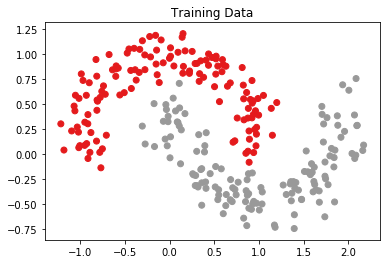

In [22]:
# Get some data
X, y = make_moons(n_samples= 300, noise=0.15, random_state=123)

# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
y_train = np.reshape(y_train, newshape=(-1, 1))
y_test = np.reshape(y_test, newshape=(-1, 1))

# Plot the training data and color the data point according to their class label
fig, axes = plt.subplots(1, 1)
axes.scatter(X_train[: , 0].reshape(X_train.shape[0],1), X_train[: , 1].reshape(X_train.shape[0],1), c=y_train, cmap='Set1')
axes.set_title('Training Data');

In the following you are allowed to use predefined functions of the TensorFlow API such as `tf.get_variable()`, `tf.nn.relu(x)` or `tf.random_normal_initializer()`. Addtionally you are allowed to use the gradient descent optimizer `tf.train.GradientDescentOptimizer` predefined by TensorFlow. However, you are not allowed to use any predefined layer from the [API](https://www.tensorflow.org/api_docs/python/tf/layers) such as `tf.Layers.Dense` or `tf.contrib.layers.fully_connected`. It is your task to implement these layers yourself.

**Before you start**: In this exercise you will implement a single hidden layer feedforward neural network. In case you are unfamiliar with the terminology and notation used here, please consult chapter 6 of the Deep Learning Book before you proceed.

Generally speaking, a feedword neural network with a single hidden layer can be represented by the following function $$ f(x;\theta) = f^{(2)}(f^{(1)}(f^{(0)}(x)))$$ where $f^{(0)}(x)$ is the input layer, $f^{(1)}(x)$ is the so called hidden layer, and $f^{(2)}(x)$ is the ouput layer of the network. $\theta$ represents the parameters of the network whose values will be learned during the training phase.

The network that you will implement in this exercise has the following layers:
* $f^{(0)}(x) = \mathbf{X}$, with $\mathbf{X} \in \mathbb{R}^{b, p}$ where $b$ is the batch size and $p$ is the number of features.
* $f^{(1)}(x) = g(\mathbf{X} \mathbf{W_1}+b_1)$, with $\mathbf{X} \in \mathbb{R}^{b, p}$, $\mathbf{W_1} \in \mathbb{R}^{p,u_1}$, $b_1 \in \mathbb{R}^{u_1}$ where $u_1$ is the number of **units** of this particular layer. Additonally, $g(x) = \max{\{0, x\}}$ is the so called **rectified linear unit** (*ReLU*) activation function. 
* $f^{(2)}(x) = \sigma(\mathbf{X} \mathbf{W_2}+b_2)$, with $\mathbf{X} \in \mathbb{R}^{b, u_1}$, $\mathbf{W_1} \in \mathbb{R}^{u_1,u_2}$, $b_1 \in \mathbb{R}^{u_2}$ where $u_2$ is the number of **units** of this particular layer. Additonally, $\sigma(x) = \frac{1}{1 + \exp{-x}}$ is the **sigmoid** function.

Note that both, $g(x)$ and $\sigma(x)$ are applied **elementwise**. Further the addition with the bias vector is also applied **elementwise** to each column of the matrix $\mathbf{X} \mathbf{W}$.

$a)$ Start the implementation of your neural network by defining functions for its different layers $f^{(0)}(x),~f^{(1)}(x),~f^{(2)}(x)$. To do so, please complete the functions skeletons below.

First, implement a linear layer that computes the linear combination $\mathbf{X} \mathbf{W}+b$ for a given `input_shape` of $x$ and a given number of hidden units `n_hidden_units`.

In [ ]:
# TODO: implement the function below.
# Hint: The following methods might be useful: tf.get_variable(), tf.random_normal_initializer(), tf.matmul(), tf.get_variable()
def linear_layer(input_shape, n_hidden_units, x):
    """
    Define a linear layer for your neural network.
    :param input_shape: The shape of the input for the layer. Be careful to consider that your data comes in batches. 
    :param n_hidden: The number of hidden units.
    :param x: The input to the layer.
    :return: A tuple where the first element is the linear combination of the input with the weights and the biases of the linear layer and the second element is the shape of the output matrix.
    """
    weights = tf.get_variable("weights", shape=(input_shape[1],n_hidden_units),
        initializer=tf.random_normal_initializer())
    biases = tf.get_variable("biases", shape=(n_hidden_units,1),
        initializer=tf.random_normal_initializer())
    output_matrix = tf.add(tf.matmul(tf.transpose(x),weights),biases)
    return (output_matrix,tf.size(output_matrix))

Next, implement a function that computes the ReLU nonlinearity.

In [ ]:
# TODO: implement the function below.
def relu(x):
    """
    Define the ReLU activation function.
    :param x: The input to the activation function.
    :return: The output of the activation function.
    """
    return tf.nn.relu(x)

Next, implement a function that computes the sigmoid nonlinearity.

In [ ]:
# TODO: implement the function below.
def sigmoid(x):
    """
    Define the sigmoid activation function.
    :param x: The input to the activation function.
    :return: The output of the activation function.
    """
    return tf.divide(1.0,1.0+tf.exp(-x))

Additional to the layers above, you need to implement a layer that computes to loss between the prediction of your model and the actual label of your data. For the **loss function** of the network we are going to use the cross entropy between the model logits and the true labels. Take a look at the TensorFlow [API](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) for further details. You also might want to take a look at page 128 in the Deep Learning Book for further information.

In [ ]:
# TODO: implement the function below.
def cross_entropy_loss(labels, unscaled_logits):
    """
    Define the cross entropy loss function between the true labels and the model predictions. Be careful to consider that your data comes in batches.
    :param labels: The true labels.
    :param unscaled_logits: The final activations produced by your model.
    :return: The loss value (a scalar).
    """
    # x = unscaled_logits
    # z = labels
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels, unscaled_logits))
    # return max(x, 0) - x * z + log(1 + exp(-abs(x)))

Using the layers above, you can now define a function that specifies the forward pass through your network. Please make sure that the first hidden layer has $128$ hidden units and the output layer has $1$ hidden unit. **Note**: Make sure that the forward pass does not compute the final prediction of your network, i.e the value returned by the function below should be used as the input to the *sigmoid* function.

In [ ]:
n_hidden_units = 128

# TODO: implement the function below. This is where you build up your model architecture using the layers defined above.
def forward(x, input_shape):
    """
    Define the forward pass of your network. Be careful to consider that your data comes in batches.
    :param x: The input to your model.
    :param input_shape: The shape of the input.
    :return: The (unscaled) logit computed by the network.
    """
    linear, shape = linear_layer(input_shape, n_hidden_units, x)

Now that the first part of the forward path of the neural network is defined, we need a function that computes the actual predictions of the model using the activations returned by `forward`.

In [ ]:
# TODO: implement the function below.
def inference(unscaled_logits):
    """
    Define the predictions computed by your network
    :param unscaled_logits: The (unscaled) logit computed by the network.
    :return: The prediction of your model on input x.
    """
    pass

Using the `cross_entropy` layer and the `forward` function defined above, please implement the loss function for your network.

In [ ]:
# TODO: implement the function below.
def loss(x, y, input_shape):
    """
    Define the loss between the prediction of your model and the actual label.
    :param x: The input to your model.
    :param y: The shape of the input.
    :param input_shape: The loss between what your model predicts and the true label.
    :return: 
    """
    pass

$b)$ Define the computation graph of your model using the functions implemented above.

So far, all that you have done was defining functions that return a **symbolic representation** of the functions computed inside your network. Remember that when using TensorFlow you always need to define a computation graph of your model. Now, use the functions implemented above to define the computation graph for your model.

In [ ]:
# Define the computational graph for your model
input_shape = (None, 2) # each input has 2 features
output_shape = (None, 1) # the output of the model is a scalar corresponding to the probability of belong to class 1 or 2.

# TODO: Define placeholers for the input and output

# TODO: Define the model final activations, predictions and loss of the network

$b)$ Now that we have defined a computation graph for our model we need to train it on training data. Hence, define the optimizer for your model and implement the training loop. After each epoch, print the accuracy of your model on the training data. Once training phase is done, evaluate the test accuracy of your model and plot the **decision boundary** of your trained model.

Hint: When evaluating the predictions of your model make sure to compute the class labels from the output of the sigmoid layer before comparing them to the ground truth labels. As a threshold use $0.5$.

In [ ]:
# TODO: Define the gradient descent optimizer
learning_rate = 1e-1

In [ ]:
# Define training parameters
epochs = 10 # we train our model for 10 epochs. You can change this value to observe how the accuracy changes.
batch_size = 10 # we use a fixed batch size of 10 data points per batch.
n = len(X_train)

# Start a Session 
with tf.Session() as sess:
    
    # TODO: Perform training
    for epoch in range(epochs):
        pass

$d)$ **Bonus**: Restructure your code in order to use TensorBoard for displaying the computation graph defined by your model. Additonally, use TensorBoard to log the training and test accuracy of your network during training. (See [here](https://www.tensorflow.org/get_started/summaries_and_tensorboard) for an introduction to TensorBoard.) (+ $2.0$ points)

## 3. Role of the activation function (3.0 points)

For this exercise it is useful to have a plot of the decision boundary of your trained model.

$a)$ Remove the nonlinearity in your TensorFlow model above, then retrain the model and evaluate its accuracy. What do you observe? ($1.0$ point)

$b$) With the nonlinearity removed, do the following: Add an additional hidden layer without nonlinearity in the `forward()` function. Retrain the model and evaluate its accuracy. What do you observe? ($1.0$ point)

$c$) What is the reason for this behaviour? Can you come up with a proof of the underlying mathematical fact? ($1.0$ point)

---

## Submission instructions
You should provide a single Jupyter notebook as a solution. The naming should include the assignment number and matriculation IDs of all team members in the following format:
**assignment-5_matriculation1_matriculation_2_matriculation3.ipynb** (in case of 3 team members). 
Make sure to keep the order matriculation1_matriculation_2_matriculation3 the same for all assignments.

Please, submit your solution to your tutor (with **[NNIA][assignment-5]** in email subject):
1. Maksym Andriushchenko s8mmandr@stud.uni-saarland.de
2. Marius Mosbach s9msmosb@stud.uni-saarland.de
3. Rajarshi Biswas rbisw17@gmail.com
4. Marimuthu Kalimuthu s8makali@stud.uni-saarland.de

**If you are in a team, please submit only 1 solution to only 1 tutor.**